In [1]:
import pandas as pd 
import numpy as np
import warnings
from matplotlib import pyplot as plt
from sklearn import metrics as m
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE # doctest: +NORMALIZE_WHITESPACE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from collections import Counter

warnings.filterwarnings('ignore')
randomseed=7

Using TensorFlow backend.


In [2]:
data1=pd.read_csv('NextYearData_actualData_train.txt')
data2=pd.read_csv('ThisYearData_actualData_train.txt')
data3=pd.read_csv('ThisYearData_actualData_test.txt')

data4=pd.read_csv('NextYearData_actualData_test.txt')

data5=pd.read_csv('Predicted_NextYearData.txt')
data5.columns=data4.columns

data=pd.concat([data1,data2,data3,data4])

print(data.shape)
data.head()

(83050, 16)


,Unnamed: 0,FIELD_1,FIELD_2,L104600,L103000,S000300,L101700,L100700,FIELD_33,FIELD_38,FIELD_40,FIELD_31,SEX,AGE,L100800,CLASS
0,0,696760,20150404,5.67,89.0,24.3,13.0,3.8,1.0,0.0,0.0,1.0,1.0,39.0,96.0,0
1,1,819364,20150923,5.80,173.0,26.2,13.0,4.8,1.0,0.0,0.0,0.0,1.0,43.0,92.0,0
2,2,816630,20170928,5.51,74.0,21.8,21.0,7.4,2.0,3.0,0.0,0.0,0.0,45.0,108.0,1
3,3,3869001,20161109,5.14,224.0,25.1,32.0,4.1,3.0,3.0,0.0,0.0,0.0,47.0,90.0,0
4,4,2853000,20161121,5.75,189.0,19.5,12.0,2.6,1.0,0.0,0.0,0.0,1.0,38.0,89.0,0


In [3]:
diabetic = data[data.CLASS==2]
prediabetic = data[data.CLASS==1]
normal = data[data.CLASS==0]

print(diabetic.shape[0],prediabetic.shape[0],normal.shape[0])

1279 22949 58822


In [4]:
diabetic_test = diabetic.sample(200,random_state=randomseed)
prediabetic_test = prediabetic.sample(200,random_state=randomseed)
normal_test = normal.sample(200,random_state=randomseed)
test=pd.concat([diabetic_test,prediabetic_test,normal_test])

diabetic_train = diabetic.drop(diabetic_test.index)
prediabetic_train = prediabetic.drop(prediabetic_test.index).sample(2*diabetic_train.shape[0],random_state=randomseed)
normal_train = normal.drop(normal_test.index).sample(2*diabetic_train.shape[0],random_state=randomseed)
train=pd.concat([diabetic_train,diabetic_train,prediabetic_train,normal_train])

In [5]:
xtrain=train.iloc[:,3:-2]
ytrain=train.iloc[:,-1]
xtest=test.iloc[:,3:-2]
ytest=test.iloc[:,-1]

In [6]:
x=data.iloc[:,3:-2]
y=data.iloc[:,-1]

sm = SMOTE(random_state=randomseed)
X_res, y_res = sm.fit_resample(x, y)

print('Resampled dataset shape %s' % Counter(y_res))
print(y_res[y_res==0].shape[0], y_res[y_res==1].shape[0], y_res[y_res==2].shape[0])
print(X_res.shape,y_res.shape)

y_res2=y_res.copy()
# from keras.utils import to_categorical
# y_res2 = to_categorical(y_res)  

xtrain,xtest,ytrain,ytest=train_test_split(X_res,y_res2,random_state=randomseed, test_size=0.2)

Resampled dataset shape Counter({0: 58822, 1: 58822, 2: 58822})
58822 58822 58822
(176466, 11) (176466,)


In [7]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(random_state=randomseed,n_estimators=100,max_depth=12,
                          min_samples_split=2, min_samples_leaf = 10, max_features =  'auto'   )
rf.fit(xtrain,ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=12, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

0.8299144330481102


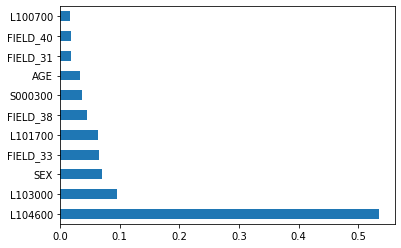

Index(['L104600', 'L103000', 'SEX', 'FIELD_33', 'L101700', 'FIELD_38',
       'S000300', 'AGE', 'FIELD_31', 'FIELD_40', 'L100700'],
      dtype='object')


In [8]:
ypred= rf.predict(xtest)

score=rf.score(xtest,ytest)
print(score)

feat_importances = pd.Series(rf.feature_importances_, index=test.iloc[:,3:-2].columns)
feat_importances.nlargest(16).plot(kind='barh')
plt.show()

print(feat_importances.nlargest(16).index)

In [9]:
print("Accuracy on training set: {:.3f}".format(rf.score(xtrain,ytrain)))
print("Accuracy on test set: {:.3f}".format(rf.score(xtest,ytest )))  

confmatrx=pd.DataFrame(m.confusion_matrix(ytest,ypred))
confmatrx.head()

Accuracy on training set: 0.843
Accuracy on test set: 0.830


,0,1,2
0,9583,2122,22
1,2435,8642,644
2,15,765,11066


In [10]:

from sklearn.metrics import classification_report 
print(classification_report(ytest, ypred))


              precision    recall  f1-score   support

           0       0.80      0.82      0.81     11727
           1       0.75      0.74      0.74     11721
           2       0.94      0.93      0.94     11846

    accuracy                           0.83     35294
   macro avg       0.83      0.83      0.83     35294
weighted avg       0.83      0.83      0.83     35294



In [11]:
import xgboost as xgb
from sklearn import metrics as m
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=randomseed)

xgb_model.fit(xtrain,ytrain)

y_pred = xgb_model.predict((xtest))

print('accuracy \t',m.accuracy_score(ytest,y_pred))
confmatrx=pd.DataFrame(m.confusion_matrix(ytest,y_pred))
confmatrx.head()

accuracy 	 0.8100527001756672


,0,1,2
0,9827,1857,43
1,2767,7980,974
2,36,1027,10783


In [12]:
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81     11727
           1       0.73      0.68      0.71     11721
           2       0.91      0.91      0.91     11846

    accuracy                           0.81     35294
   macro avg       0.81      0.81      0.81     35294
weighted avg       0.81      0.81      0.81     35294



In [13]:
# =====================================
pred5= rf.predict((data5.iloc[:,3:-2]))

print(m.accuracy_score(data5.iloc[:,-1],pred5))

confmatrx=pd.DataFrame(m.confusion_matrix(data5.iloc[:,-1],pred5))
confmatrx

0.71552416118157


,0,1,2
0,6601,1962,17
1,1354,2156,132
2,8,71,157


In [14]:
print(classification_report(data5.iloc[:,-1], pred5))

              precision    recall  f1-score   support

           0       0.83      0.77      0.80      8580
           1       0.51      0.59      0.55      3642
           2       0.51      0.67      0.58       236

    accuracy                           0.72     12458
   macro avg       0.62      0.68      0.64     12458
weighted avg       0.73      0.72      0.72     12458

